In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as ma
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [5]:
def get_csv(path: str) -> pd.DataFrame:
    
    return pd.read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price', '24h High (USD)': 'high', '24h Low (USD)': 'low'})


def transform_df(df: pd.DataFrame) -> pd.DataFrame:

    transformed_df = pd.DataFrame(columns = ['date', 'price', 'previous price', 'previous high', 'previous low'])

    for i in range(1, df.shape[0]):
        transformed_df.loc[i - 1] = {'date': df.loc[i]['date'], 'price': df.loc[i]['price'], 'previous price': df.loc[i - 1]['price'], 'previous high': df.loc[i - 1]['high'], 'previous low': df.loc[i - 1]['low']}

    return transformed_df

In [6]:
df_ada = transform_df(get_csv('./data/cardano.csv'))

In [7]:
model_ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 4), n_estimators = 30)
model_ada.fit(df_ada[['previous price', 'previous high', 'previous low']][:ma.floor(df_ada.shape[0] * 0.7)].to_numpy(), df_ada['price'][:ma.floor(df_ada.shape[0] * 0.7)])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=30)

In [8]:
pred = pd.Series(model_ada.predict(df_ada[['previous price', 'previous high', 'previous low']][ma.floor(df_ada.shape[0] * 0.7):].to_numpy()), index = df_ada.index[ma.floor(df_ada.shape[0] * 0.7):])

In [9]:
np.round(np.mean(abs(1 - (pred / df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):]))) * 100, 2)

3.98

In [10]:
model_ada.predict(df_ada[['previous price', 'previous high', 'previous low']][ma.floor(df_ada.shape[0] * 0.7):].to_numpy())/df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):]

193    1.022004
194    0.989077
195    1.009596
196    0.982736
197    0.997071
         ...   
272    0.995886
273    1.032291
274    0.979236
275    0.979806
276    1.029912
Name: price, Length: 84, dtype: float64

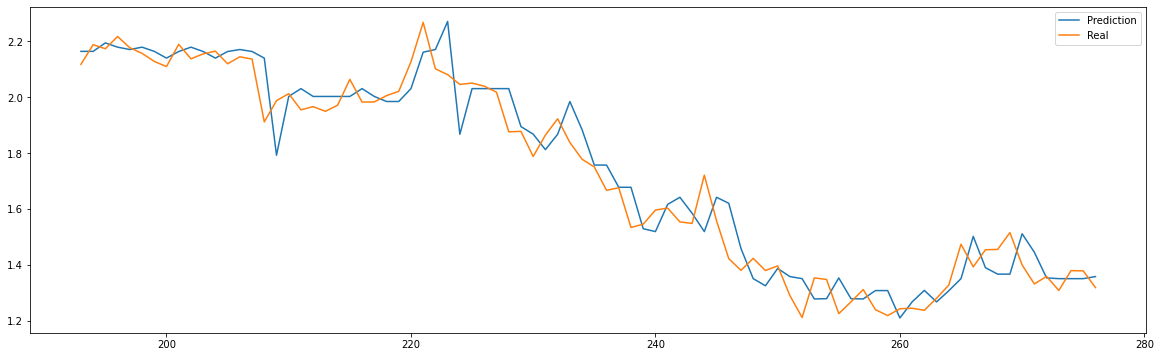

In [11]:
plt.figure(figsize = (20, 6))
plt.plot(pred, label = 'Prediction')
plt.plot(df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):], label = 'Real')
plt.legend(loc = 'best')
plt.show()

In [12]:
def n_estimators_max_depth_test(df: pd.DataFrame, max_depth: int = 3, max_estimators: int = 50, test_ratio: float = 0.3) -> pd.DataFrame:
    result = pd.DataFrame(columns = ['n_estimators','max_depth', 'mape'])
    
    for n_estimators in range(1, max_estimators + 1):
        for depth in range(1, max_depth + 1):
            train_x = df[['previous price', 'previous high', 'previous low']][:ma.floor(df.shape[0] * (1 - test_ratio))].to_numpy()
            train_y = df['price'][:ma.floor(df.shape[0] * (1 - test_ratio))]
            test_x = df[['previous price', 'previous high', 'previous low']][ma.floor(df.shape[0] * (1 - test_ratio)):].to_numpy()
            test_y = df['price'][ma.floor(df.shape[0] * 0.7):]
            model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = depth), n_estimators = n_estimators)
            model.fit(train_x, train_y)
            pred = model.predict(test_x)
            mape = np.round(np.mean(abs(1 - (pred / test_y))) * 100, 2)
            result.loc[result.shape[0]] = {'n_estimators': n_estimators, 'max_depth': depth, 'mape': mape}

    return result


def n_estimators_test(df: pd.DataFrame, max_depth: int = 3, max_estimators: int = 50, test_ratio: float = 0.3) -> pd.DataFrame:
    result = pd.DataFrame(columns = ['n_estimators', 'mape'])

    for n_estimators in range(1, max_estimators + 1):
        train_x = df[['previous price', 'previous high', 'previous low']][:ma.floor(df.shape[0] * (1 - test_ratio))].to_numpy()
        train_y = df['price'][:ma.floor(df.shape[0] * (1 - test_ratio))]
        test_x = df[['previous price', 'previous high', 'previous low']][ma.floor(df.shape[0] * (1 - test_ratio)):].to_numpy()
        test_y = df['price'][ma.floor(df.shape[0] * 0.7):]
        model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = max_depth), n_estimators = n_estimators)
        model.fit(train_x, train_y)
        pred = model.predict(test_x)
        mape = np.round(np.mean(abs(1 - (pred / test_y))) * 100, 2)
        result.loc[result.shape[0]] = {'n_estimators': n_estimators, 'mape': mape}

    return result

In [13]:
idk = n_estimators_max_depth_test(df_ada, max_depth = 4)

In [14]:
idk = n_estimators_test(df_ada, max_depth = 4)

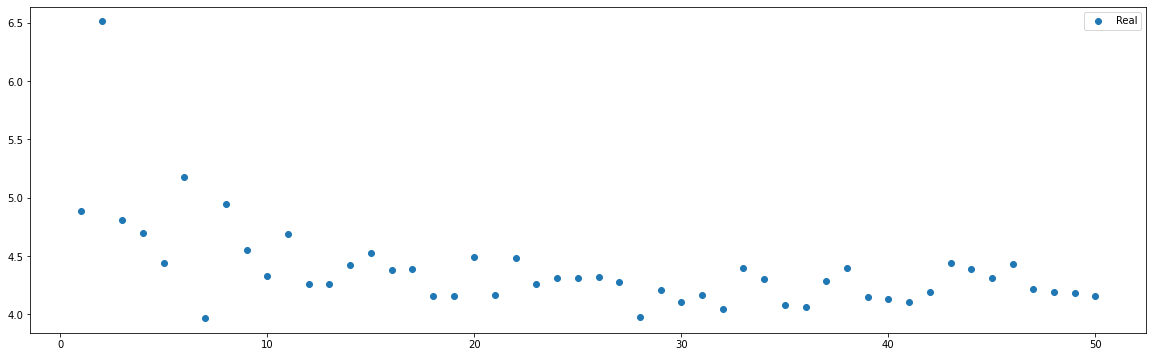

In [15]:
plt.figure(figsize = (20, 6))
plt.scatter(x = idk['n_estimators'], y = idk['mape'], label = 'Real')
plt.legend(loc = 'best')
plt.show()

In [16]:
idk.sort_values(by = ['mape'])
model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 4), n_estimators = 35)
model.fit(df_ada[['previous price', 'previous high', 'previous low']][:ma.floor(df_ada.shape[0] * 0.7)].to_numpy(), df_ada['price'][:ma.floor(df_ada.shape[0] * 0.7)])
pred = pd.Series(model.predict(df_ada[['previous price', 'previous high', 'previous low']][ma.floor(df_ada.shape[0] * 0.7):].to_numpy()), index = df_ada.index[ma.floor(df_ada.shape[0] * 0.7):])
np.round(np.mean(abs(1 - (pred / df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):]))) * 100, 2)

4.36

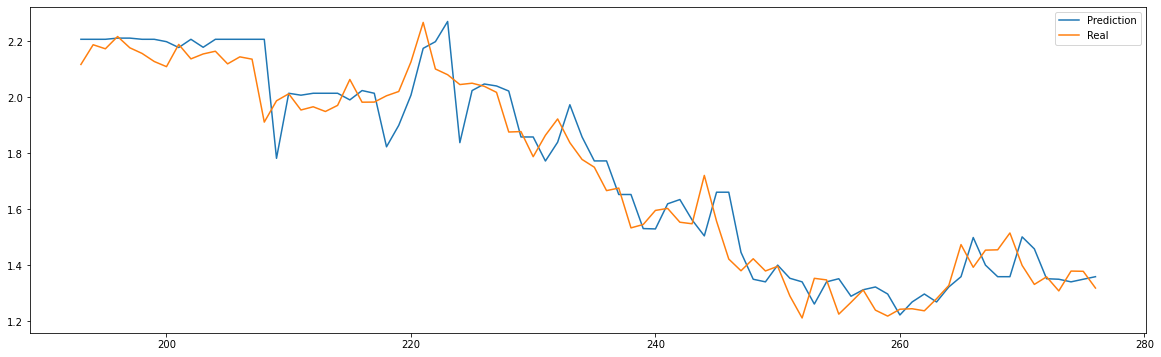

In [17]:
plt.figure(figsize = (20, 6))
plt.plot(pred, label = 'Prediction')
plt.plot(df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):], label = 'Real')
plt.legend(loc = 'best')
plt.show()

In [27]:
def rolling_adaboost(df: pd.DataFrame, max_depth: int = 3, n_estimators: int = 50, test_ratio: float = 0.3) -> pd.DataFrame:
    test_x = df[['previous price', 'previous high', 'previous low']][ma.floor(df.shape[0] * (1 - test_ratio)):]
    test_y = df['price'][ma.floor(df.shape[0] * (1 - test_ratio)):]
    pred = pd.Series(dtype = np.float64)
 
    for i in test_y.index:
        train_x = df[['previous price', 'previous high', 'previous low']][:i].to_numpy()
        train_y = df['price'][:i]

        model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = max_depth), n_estimators = n_estimators)
        model.fit(train_x, train_y)
        pred.loc[i] = model.predict([test_x.loc[i].to_numpy()])[0]
    
    return pred
    

def MAPE(pred, real) -> float:
    return np.mean(abs(1 - (pred / real)))


def RMSE(pred, real):
    return np.sqrt(np.mean((real - pred) ** 2))

In [35]:
rolling_ada = rolling_adaboost(df_ada, 4, 35)

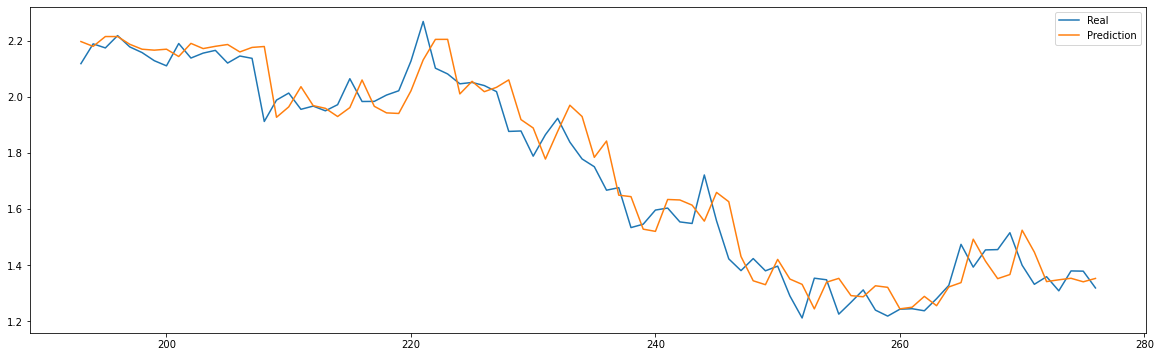

In [32]:
plt.figure(figsize = (20, 6))
plt.plot(df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):], label = 'Real')
plt.plot(rolling_ada, label = 'Prediction')
plt.legend(loc = 'best')
plt.show()

In [36]:
MAPE(rolling_ada, df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):])

0.04044954803070681